In [12]:
import torch
import pickle
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss

import importlib
from model.MedClinical import Biobert_fc 


from tqdm import tqdm_notebook, trange
import os
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification, BertForTokenClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

from multiprocessing import Pool, cpu_count
from util.tools  import *
from util import convert_examples_to_features

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

### Define parameters

In [13]:
DATA_DIR = "data/"

# Bert pre-trained model selected in the list: bert-base-uncased, 
# bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased,
# bert-base-multilingual-cased, bert-base-chinese.
BERT_MODEL = 'bert-base-cased'

# The name of the task to train.I'm going to name this 'yelp'.
TASK_NAME = 'Relation Extraction'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = f'outputs/{TASK_NAME}/'

# The directory where the evaluation reports will be written to.
REPORTS_DIR = f'reports/{TASK_NAME}_evaluation_report/'

# This is where BERT will look for pre-trained models to load parameters from.
CACHE_DIR = 'cache/'

# The maximum total input sequence length after WordPiece tokenization.
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.
MAX_SEQ_LENGTH = 128

TRAIN_BATCH_SIZE = 24
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 10
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1


CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"

### Create Directories, if doesn't exist

In [14]:
if os.path.exists(REPORTS_DIR) and os.listdir(REPORTS_DIR):
        REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
        os.makedirs(REPORTS_DIR)
if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)
    
# if os.path.exists(OUTPUT_DIR) and os.listdir(OUTPUT_DIR):
#         raise ValueError("Output directory ({}) already exists and is not empty.".format(OUTPUT_DIR))
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [15]:
processor = MultiClassificationProcessor()
train_examples = processor.get_train_examples(DATA_DIR)
train_examples_len = len(train_examples)

In [16]:
train_examples_len

76318

In [17]:
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)
num_labels, label_list

(9,
 ['Reason-Drug',
  'Route-Drug',
  'Strength-Drug',
  'Frequency-Drug',
  'Duration-Drug',
  'Form-Drug',
  'Dosage-Drug',
  'ADE-Drug',
  'no relation'])

In [18]:
num_train_optimization_steps = int(
    train_examples_len / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS) * NUM_TRAIN_EPOCHS

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at C:\Users\pnarsina\.pytorch_pretrained_bert\5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1


In [20]:
train_examples_for_processing = [(example,  MAX_SEQ_LENGTH, tokenizer) for example in train_examples]
len(train_examples_for_processing)

76318

### Convert Inputs to features in parallel threads -- Below 2 cells are commented, as it is needed only one time. We will use cached file from second time onwards

In [10]:
process_count = cpu_count() - 1
with Pool(process_count) as p:
    train_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, train_examples_for_processing), total=train_examples_len))

<ipython-input-10-e0729e043d4e>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  train_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, train_examples_for_processing), total=train_examples_len))


In [11]:
with open(DATA_DIR + "train_features.pkl", "wb") as f:
    pickle.dump(train_features, f)

In [21]:
with open(DATA_DIR + "train_features.pkl", "rb") as f:
    train_features = pickle.load(f)

In [25]:
# model = BertForSequenceClassification.from_pretrained(BERT_MODEL, cache_dir=CACHE_DIR, num_labels=num_labels)

model = Biobert_fc()

In [35]:
x = model.to(device)

In [27]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
# param_optimizer

In [28]:

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP_PROPORTION,
                     t_total=num_train_optimization_steps)

In [29]:
global_step = 0
nb_tr_steps = 0
tr_loss = 0

In [30]:
logger.info("***** Running training *****")
logger.info("  Num examples = %d", train_examples_len)
logger.info("  Batch size = %d", TRAIN_BATCH_SIZE)
logger.info("  Num steps = %d", num_train_optimization_steps)
all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
all_label_ids = torch.tensor([int(f.label_id) for f in train_features], dtype=torch.long)



INFO:root:***** Running training *****
INFO:root:  Num examples = 76318
INFO:root:  Batch size = 24
INFO:root:  Num steps = 31790


In [31]:
# torch.tensor([f.label_id for f in train_features])

In [32]:
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=TRAIN_BATCH_SIZE)

In [21]:
model.train()
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

#         logits = model(input_ids, segment_ids, input_mask, labels=None)
        logits = model(input_ids, segment_ids, input_mask)

        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        print("\r%f" % loss, end='')
        
        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]<ipython-input-21-5920486dd2b1>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):


2.215578

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_pretrained_bert\optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


0.115925

Epoch:  10%|███████▎                                                                 | 1/10 [13:44<2:03:38, 824.29s/it]

0.260424


0.054284

Epoch:  20%|██████████████▌                                                          | 2/10 [27:26<1:49:50, 823.81s/it]

0.006128


0.001317

Epoch:  30%|█████████████████████▉                                                   | 3/10 [41:09<1:36:03, 823.39s/it]

0.004640


0.036091

Epoch:  40%|█████████████████████████████▏                                           | 4/10 [54:52<1:22:19, 823.30s/it]

0.039521


0.002822

Epoch:  50%|███████████████████████████████████▌                                   | 5/10 [1:08:35<1:08:35, 823.17s/it]

0.000986


0.000588

Epoch:  60%|███████████████████████████████████████████▊                             | 6/10 [1:22:15<54:49, 822.37s/it]

0.027578


0.112964

Epoch:  70%|███████████████████████████████████████████████████                      | 7/10 [1:35:57<41:06, 822.08s/it]

0.000528


0.000411

Epoch:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [1:49:38<27:23, 821.73s/it]

0.000356


0.082666

Epoch:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [2:03:18<13:41, 821.23s/it]

0.000532


0.000625

0.050235

0.000356

0.041590

0.033590

0.000300

0.000353

0.000267

0.068845

Epoch: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [2:16:58<00:00, 821.88s/it]

0.048153


In [26]:
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(OUTPUT_DIR, WEIGHTS_NAME)
output_config_file = os.path.join(OUTPUT_DIR, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
torch.save(model, OUTPUT_DIR + 'best_mdel')
# model_to_save.config.to_json_file(output_config_file)
# tokenizer.save_vocabulary(OUTPUT_DIR)

## Now, let us evaluate on Training Set

In [33]:
# model = Biobert_fc()
# # model =  BertModel.from_pretrained((BERT_MODEL))
# path = OUTPUT_DIR +  'pytorch_model.bin'
# model.load_state_dict(torch.load(path))
# x = model.to(device)
# model.eval()

Biobert_fc(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [36]:
import numpy as np
model.eval()
train_loss = 0
nb_train_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(train_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        logits = model(input_ids, segment_ids, input_mask)

    # create eval loss and other metric required by the task
    loss_fct = CrossEntropyLoss()
    tmp_train_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))

    train_loss += tmp_train_loss.mean().item()

    nb_train_steps += 1
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

train_loss = train_loss / nb_train_steps
preds = preds[0]
preds = np.argmax(preds, axis=1)

<ipython-input-36-deb74574cbf2>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(train_dataloader, desc="Evaluating"):


In [37]:
len(preds), len(all_label_ids)

(76318, 76318)

In [38]:
import json
CONFIG_FOLDER = 'config/'
id_label_file = 'id_2_label.json'
with open(CONFIG_FOLDER + id_label_file) as infile:
    id2label = json.load(infile)

In [39]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix

preds_labels = [id2label[str(p)] for p in preds]
all_labels =  [id2label[str(l)] for l in all_label_ids.numpy()]
mcc = matthews_corrcoef(all_labels, preds_labels)

print('Correlation Coefficient is ', mcc)

mismatches = []
all_rels = []
for row in range(len(all_labels)):
    all_rels.append([all_labels[row], preds_labels[row]])
    if preds_labels[row] != all_labels[row]:
        mismatches.append([all_labels[row], preds_labels[row]])
        

Correlation Coefficient is  0.0016863562955186523


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


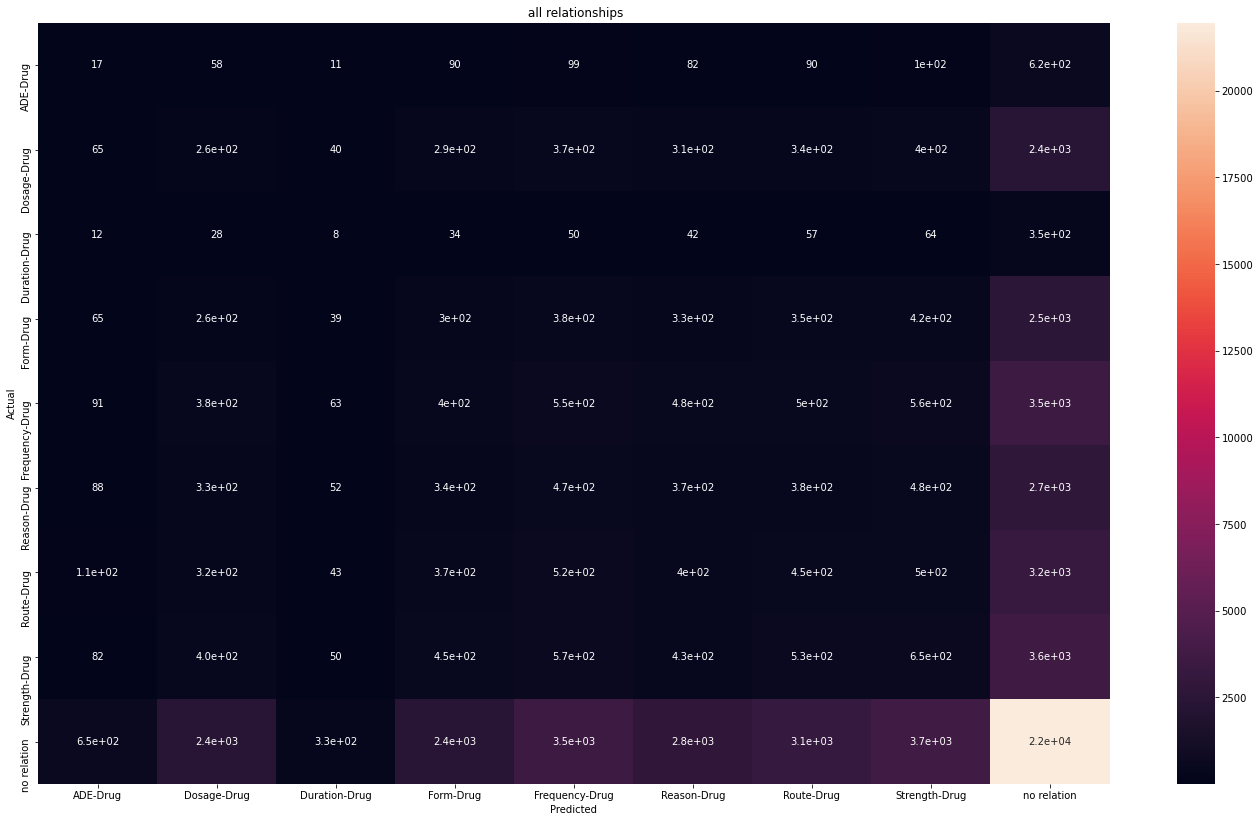

In [40]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

df = pd.DataFrame(all_rels, columns = ['labels', 'predicted'])
# df.head(10)
plt.figure(figsize=(24,14))
plt.title(" all relationships")
confusion_matrix = pd.crosstab(df['labels'], df['predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)

plt.show()


In [41]:
from sklearn import metrics
metrics.f1_score(df["labels"], df["predicted"], average='micro')

0.3217720590162216

In [61]:
df["matched"] = df["labels"] == df["predicted"]
# df["nomatch"] = df["labels"] != df["predicted"]
df.groupby(["labels", "matched"]).count()

predicted  nomatch
labels         matched                    
ADE-Drug       False         1150     1150
               True            17       17
Dosage-Drug    False         4196     4196
               True           259      259
Duration-Drug  False          637      637
               True             8        8
Form-Drug      False         4347     4347
               True           296      296
Frequency-Drug False         5937     5937
               True           547      547
Reason-Drug    False         4892     4892
               True           371      371
Route-Drug     False         5479     5479
               True           446      446
Strength-Drug  False         6132     6132
               True           649      649
no relation    False        18991    18991
               True         21964    21964